## Test LaSR datasets

In [45]:
import sys
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions')

import src.SR_benchmarking.dataset.utils as utils
from importlib import reload
reload(utils)
import pandas as pd

In [48]:
data = utils.load_datasets('pysr-difficult', 1000, 1e-4, equation_indices=[-3361], forbid_ops=['log'])[0]
i = 1

print(data.equation)
print(data.X[:, i].min(), data.X[:, i].max())

ValueError: PySR-difficult dataset numbering starts at 0 and goes up to 3360.

In [ ]:
expr = 'x0 * x1 + x2 - sinh(x1)'
utils.create_dataset_from_expression(expr, 100, 1e-4)

SyntaxError: invalid syntax (635719521.py, line 6)

## PySR integration tests

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [6]:
from pysr import PySRRegressor, TensorBoardLoggerSpec
from pysr_interface_utils import get_mutation_stats, reset_mutation_stats
from importlib import reload
import src.SR_benchmarking.dataset.utils as utils
reload(utils)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   GPUArrays [0c68f7d7-f131-5f86-a1c3-88cf8149b2d7]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   ArrayInterfaceCUDAExt [f78586ac-ba87-5ec7-b3a5-84bc1b258ee3]
│   Optim [429524aa-4258-5aef-a3af-852621145aeb]
│   cuDNN [02a925ec-e4fe-4b08-9a7e-0d78e3d38ccd]
│   DifferentiationInterfaceFiniteDiffExt [6044458a-139e-583a-bc2f-a730a9b54282]
│   NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c]
│   CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
│   SymbolicRegression [8254be44-1295-4e6a-a16d-46603ac705cb]
│   FiniteDiffSparseArraysExt [699899dd-2948-59d9-a4f6-ce210f3f1f61]
│   SparseArraysExt [85068d23-b5fb-53f1-8204-05c2aba6942f]
│   DynamicExpressionsOptimExt [5458d0c1-52ec-57a8-a2ac-7e1b9fb3c3b9]
│   AtomixCUDAExt [13011619-4c7c-5ef0-948f-5fc81565cd05]
│   LinearAlgebraExt [66d79d19-2cc4-5b0b-ac7a-b340256d1ecd]
│   FiniteDiff [6a8

<module 'dataset_utils' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/sr_inference_benchmarking/dataset_utils.py'>

In [8]:
def eval_equation(X, y, n_iterations=10, early_stopping_condition=1e-8, sample_eps=0.01, neural_mutate_tree_weight=0.0):
    custom_loss = """
    function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
        prediction, flag = eval_tree_array(tree, dataset.X, options)
        if !flag
            return L(Inf)
        end
        return sum( (1000 .* (prediction .- dataset.y) ) .^ 2) / dataset.n
    end
    """

    # Load model
    model_id = 'e51hcsb9'
    
    logger_spec = TensorBoardLoggerSpec(
        log_dir="logs/run",
        log_interval=10,  # Log every 10 iterations
    )

    model = PySRRegressor(
        niterations=n_iterations,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=["cos","exp","sin","zero_sqrt(x) = x >= 0 ? sqrt(x) : zero(x)"],
        extra_sympy_mappings={"zero_sqrt": lambda x: x},  # TODO: Not using Sympy rn. Fix this.
        precision=64,
        neural_options=dict(
            active=True,
            # model_path=f'/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/ONNX/onnx-models/model-{model_id}.onnx',
            model_path=f'/home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-{model_id}.onnx',
            sampling_eps=sample_eps,
            subtree_min_nodes=2,
            subtree_max_nodes=14,
            device="cuda",
            verbose=True,
            max_tree_size_diff=7,
            require_tree_size_similarity=True,
            require_novel_skeleton=True,
            require_expr_similarity=True,
            similarity_threshold=0.2,
            max_resamples=127,
            sample_batchsize=32,
            sample_logits=True,
            log_subtree_strings=True,
            subtree_max_features=2
        ),
        weight_neural_mutate_tree=neural_mutate_tree_weight,
        # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        loss_function=custom_loss,
        early_stop_condition=f"f(loss, complexity) = (loss < {early_stopping_condition:e})",
        logger_spec=logger_spec,
        # populations=10,
        # population_size=10,
        # tournament_selection_n=5,
    )
    model.fit(X, y)
    return model

In [10]:
# expr = 'cos(x0)/(x0+2)+x0 + (x1 - sqrt(x1))/exp(x1+3)'
# dataset = dataset_utils.create_dataset_from_expression(expr, 500, 0)
# X, y = dataset.X, dataset.y

dataset = utils.load_datasets('feynman', num_samples=2000, noise=0, equation_indices=[35])[0]
dataset.equation
X, y = dataset.X, dataset.y

In [ ]:
reset_mutation_stats()
model = eval_equation(X, y, n_iterations=1, early_stopping_condition=1e-8, sample_eps=0.02, neural_mutate_tree_weight=1.0)

/mhome/damtp/q/lc865/workspace/similar-expressions/PySR/pysr/sr.py:2797: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


In [49]:
stats = get_mutation_stats()
in_sizes, out_sizes = stats['subtree_in_sizes'], stats['subtree_out_sizes']

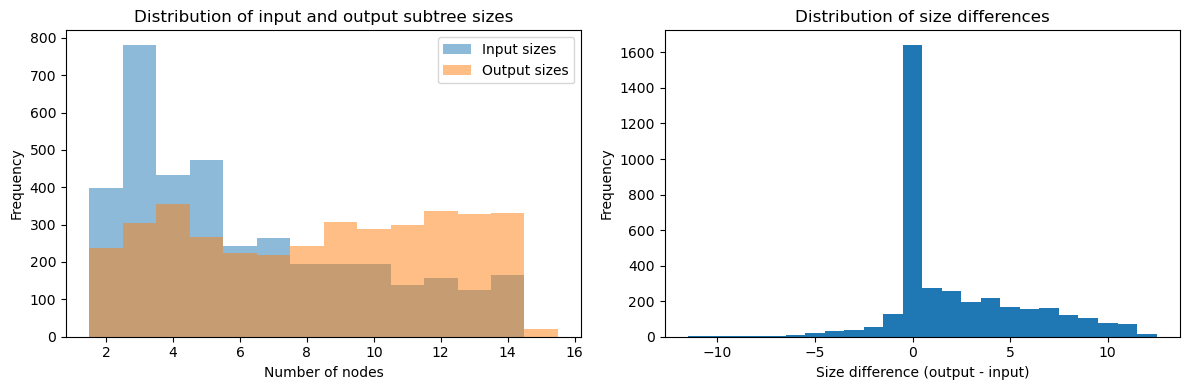

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histograms of in and out sizes on first subplot
ax1.hist(in_sizes, alpha=0.5, label='Input sizes', bins=range(min(in_sizes), max(in_sizes)+2), align='left')
ax1.hist(out_sizes, alpha=0.5, label='Output sizes', bins=range(min(out_sizes), max(out_sizes)+2), align='left')
ax1.set_xlabel('Number of nodes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of input and output subtree sizes')
ax1.legend()

# Plot histogram of differences on second subplot
differences = [out - in_ for out, in_ in zip(out_sizes, in_sizes)]
ax2.hist(differences, bins=range(min(differences), max(differences)+2), align='left')
ax2.set_xlabel('Size difference (output - input)')
ax2.set_ylabel('Frequency') 
ax2.set_title('Distribution of size differences')

plt.tight_layout()
plt.show()


In [4]:
raw_stats = """decoding_failures: 0
encoding_failures: 0
expr_similarity_failures: 478175
module_not_enabled: 0
multivariate_decoding_attempts: 6802818
new_subtree_string: []
new_tree_eval_failures: 454422
no_subtree_found: 31
orig_subtree_string: []
orig_tree_eval_failures: 2370121
returned_nonsimilar_exprs: 2649
returned_similar_exprs: 65820
sample_routine_failures: 43957
sampled_mse_mean: 0.4
sampled_mse_std: 10.8
sampled_mse_ninvalid: 0
skeleton_not_novel: 299809
subtree_in_sizes_mean: 5.6
subtree_in_sizes_std: 3.3
subtree_in_sizes_ninvalid: 0
subtree_out_sizes_mean: 7.3
subtree_out_sizes_std: 3.6
subtree_out_sizes_ninvalid: 0
successful_mutations: 68469
total_attempts: 112428
total_samples: 6726788
total_tree_sizes_mean: 18.4
total_tree_sizes_std: 9.0
total_tree_sizes_ninvalid: 0
tree_build_failures: 5784058
tree_comparison_failures: 98947"""

# Parse raw stats string into dictionary
stats = {}
for line in raw_stats.split('\n'):
    key, value = line.split(': ')
    try:
        # Try to convert to int first
        stats[key] = int(value)
    except ValueError:
        try:
            # If not int, try float
            stats[key] = float(value)
        except ValueError:
            # If neither, treat as string/list
            if value.startswith('[') and value.endswith(']'):
                # Parse as list
                stats[key] = eval(value)
            else:
                # Keep as string
                stats[key] = value


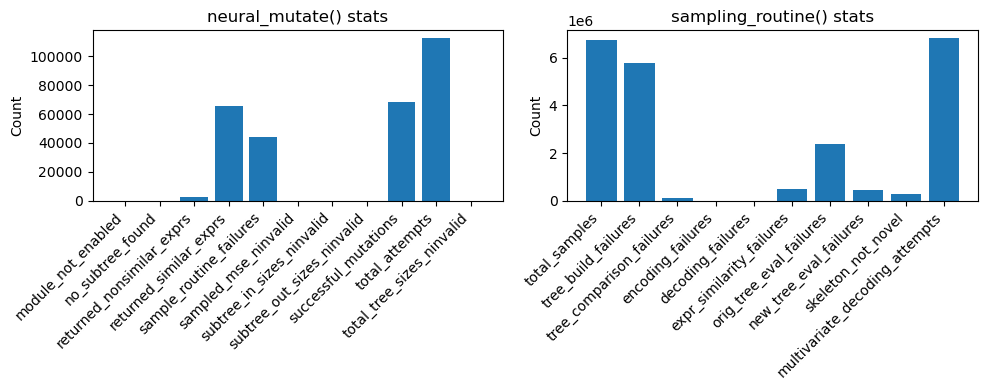

In [5]:
# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Stats to show on right subplot
right_stats = ['total_samples', 'tree_build_failures', 'tree_comparison_failures', 'encoding_failures', 'decoding_failures', 'expr_similarity_failures', 'orig_tree_eval_failures', 'new_tree_eval_failures', 'skeleton_not_novel', 'multivariate_decoding_attempts']

# Left subplot with all other stats
left_stats = {k: v for k, v in count_stats.items() if k not in right_stats}
ax1.bar(left_stats.keys(), left_stats.values())
ax1.set_xticks(range(len(left_stats)))
ax1.set_xticklabels(left_stats.keys(), rotation=45, ha='right')
ax1.set_title('neural_mutate() stats')
ax1.set_ylabel('Count')

# Right subplot with selected stats
right_stats = {k: count_stats[k] for k in right_stats}
ax2.bar(right_stats.keys(), right_stats.values())
ax2.set_xticks(range(len(right_stats)))
ax2.set_xticklabels(right_stats.keys(), rotation=45, ha='right')
ax2.set_title('sampling_routine() stats')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

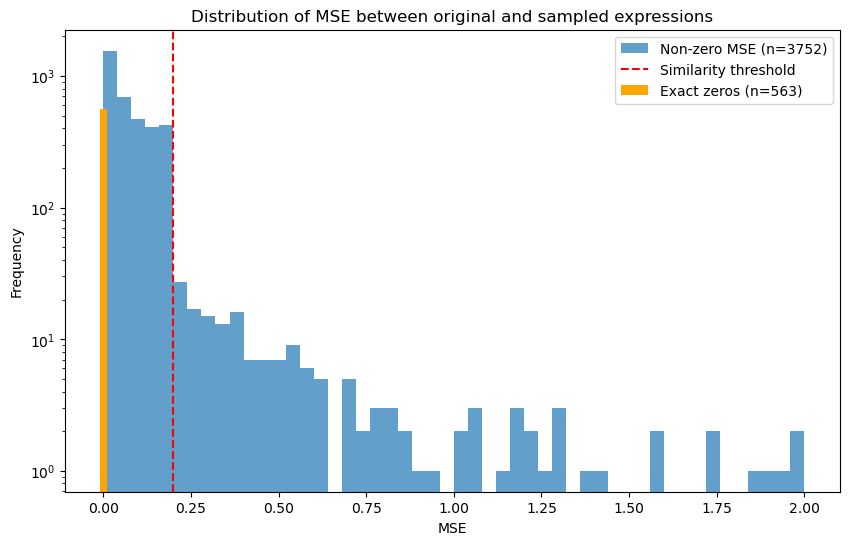

In [41]:
# Plot histogram of MSE values
similarity_threshold = 0.2

plt.figure(figsize=(10, 6))

# Count number of exact zeros
num_zeros = sum(x == 0 for x in stats['sampled_mse'])

# Plot main histogram excluding zeros
non_zero_mse = [x for x in stats['sampled_mse'] if x > 0]
plt.hist(non_zero_mse, bins=50, range=(0, min(max(stats['sampled_mse']), 2.0)), 
         label=f'Non-zero MSE (n={len(non_zero_mse)})', alpha=0.7)

# Add bar for zeros at x=0
plt.bar(0, num_zeros, width=0.02, color='orange', label=f'Exact zeros (n={num_zeros})')

plt.axvline(x=similarity_threshold, color='r', linestyle='--', label='Similarity threshold')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Distribution of MSE between original and sampled expressions')
plt.yscale('log')  # Use log scale since MSE values can span many orders of magnitude
plt.legend()
plt.show()


In [42]:
for a, b, c in zip(stats['orig_subtree_string'], stats['new_subtree_string'], stats['sampled_mse'][:20]):
    print(f'Original: {a}')
    print(f'Sampled: {b}')
    print(f'MSE: {c}')
    print('-'*100)

Original: exp(x2)
Sampled: exp((x2 * x2) / x2)
MSE: 0.0
----------------------------------------------------------------------------------------------------
Original: exp(x2 * sin(-0.801423884564155))
Sampled: exp(sin(sin(-0.8196454)) * x2)
MSE: 0.041306111961603165
----------------------------------------------------------------------------------------------------
Original: zero_sqrt(0.5971894944413725 * exp(x1))
Sampled: zero_sqrt(0.7212498 * exp(x1))
MSE: 0.004267546813935041
----------------------------------------------------------------------------------------------------
Original: cos(0.8454969808266442 * x1)
Sampled: cos(0.7657887 * x1)
MSE: 0.09888306260108948
----------------------------------------------------------------------------------------------------
Original: -1.4323266286005063 - x2
Sampled: -1.2316458 - x2
MSE: 0.005999921355396509
----------------------------------------------------------------------------------------------------
Original: zero_sqrt(x2)
Sampled: z

/tmp/ipykernel_2445048/3836838500.py:21: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x > 0, np.sqrt(x), 0)


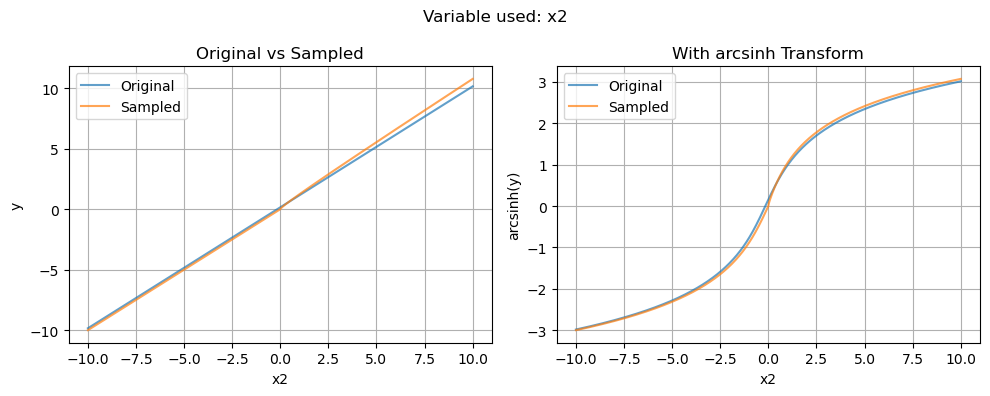

In [30]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify
import re

def plot_expressions(expr_str):
    # Extract original and sampled expressions
    lines = expr_str.strip().split('\n')
    if len(lines) < 2:
        raise ValueError("Input must contain at least 2 lines with 'Original:' and 'Sampled:' expressions")
        
    orig = lines[0].replace('Original: ', '').strip()
    sampled = lines[1].replace('Sampled: ', '').strip()
    
    if not orig or not sampled:
        raise ValueError("Could not parse empty expressions")
    
    # Define the zero_sqrt function
    def zero_sqrt(x):
        return np.where(x > 0, np.sqrt(x), 0)
    
    # Find the single xi variable in both expressions
    var_pattern = re.compile(r'x\d+')
    var_orig = var_pattern.findall(orig)
    var_sampled = var_pattern.findall(sampled)
    
    # Get the single variable (should be same in both expressions)
    var = var_orig[0] if var_orig else var_sampled[0]
    
    try:
        # Create sympy symbol for the variable
        x_sym = sp.Symbol(var)
        
        # Convert strings to sympy expressions
        orig_expr = sp.sympify(orig)
        sampled_expr = sp.sympify(sampled)
        
        # Convert to numpy functions
        orig_func = lambdify(x_sym, orig_expr, modules=[{'zero_sqrt': zero_sqrt}, 'numpy'])
        sampled_func = lambdify(x_sym, sampled_expr, modules=[{'zero_sqrt': zero_sqrt}, 'numpy'])
        
        # Generate x values
        x = np.linspace(-10, 10, 1000)
        
        # Calculate y values
        y_orig = orig_func(x)
        y_sampled = sampled_func(x)
        
        # Ensure y values are arrays with same shape as x
        if np.isscalar(y_orig):
            y_orig = np.full_like(x, y_orig)
        if np.isscalar(y_sampled):
            y_sampled = np.full_like(x, y_sampled)
        
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        # Regular plot
        ax1.plot(x, y_orig, label='Original', alpha=0.7)
        ax1.plot(x, y_sampled, label='Sampled', alpha=0.7)
        ax1.set_xlabel(var)
        ax1.set_ylabel('y')
        ax1.set_title('Original vs Sampled')
        ax1.legend()
        ax1.grid(True)
        
        # Plot with arcsinh transform
        ax2.plot(x, np.arcsinh(y_orig), label='Original', alpha=0.7)
        ax2.plot(x, np.arcsinh(y_sampled), label='Sampled', alpha=0.7)
        ax2.set_xlabel(var)
        ax2.set_ylabel('arcsinh(y)')
        ax2.set_title('With arcsinh Transform')
        ax2.legend()
        ax2.grid(True)
        
        plt.suptitle(f'Variable used: {var}')
        plt.tight_layout()
        plt.show()
        
    except (sp.SympifyError, ValueError) as e:
        print(f"Error parsing expressions: {e}")
        return

# Example usage with error handling
example = """Original: cos(exp(0.3450647190960898)) + x2
Sampled: x2 + (0.24503982 * ((zero_sqrt(x2) - x2) + x2))"""

plot_expressions(example)


In [13]:
import pandas as pd
pd.Series(stats['sampled_mse']).value_counts()

0.000000e+00    754
inf              99
6.512391e-02     21
4.962862e-03     19
2.125945e-08     19
               ... 
6.229788e-04      1
4.853453e-03      1
5.386262e-04      1
6.365492e-03      1
1.290172e-06      1
Name: count, Length: 691, dtype: int64

## Reading TensorBoard data

In [21]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
log_basedir = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round2/test1'
event_acc = EventAccumulator(log_basedir)
event_acc.Reload()
# Show all tags in the log file
res = event_acc.Tags()

# # E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
# w_times, step_nums, vals = zip(*event_acc.Scalars('Accuracy'))

In [23]:
event_acc.Tags()['scalars']

['search/data/summaries/min_loss',
 'search/data/summaries/pareto_volume',
 'search/data/num_evals',
 'search/data/equations/complexity=10/loss',
 'search/data/equations/complexity=18/loss',
 'search/data/equations/complexity=7/loss',
 'search/data/equations/complexity=2/loss',
 'search/data/equations/complexity=1/loss',
 'search/data/equations/complexity=11/loss',
 'search/data/equations/complexity=15/loss',
 'search/data/equations/complexity=5/loss',
 'search/data/equations/complexity=14/loss',
 'search/data/equations/complexity=3/loss',
 'search/data/equations/complexity=6/loss',
 'search/data/equations/complexity=4/loss',
 'search/data/equations/complexity=12/loss',
 'search/data/equations/complexity=16/loss',
 'search/data/equations/complexity=9/loss',
 'search/data/equations/complexity=8/loss']

In [25]:
for k, v in res.items():
    print(k, v)

images []
audio []
histograms ['search/data/population/complexities']
scalars ['search/data/summaries/min_loss', 'search/data/summaries/pareto_volume', 'search/data/num_evals', 'search/data/equations/complexity=10/loss', 'search/data/equations/complexity=18/loss', 'search/data/equations/complexity=7/loss', 'search/data/equations/complexity=2/loss', 'search/data/equations/complexity=1/loss', 'search/data/equations/complexity=11/loss', 'search/data/equations/complexity=15/loss', 'search/data/equations/complexity=5/loss', 'search/data/equations/complexity=14/loss', 'search/data/equations/complexity=3/loss', 'search/data/equations/complexity=6/loss', 'search/data/equations/complexity=4/loss', 'search/data/equations/complexity=12/loss', 'search/data/equations/complexity=16/loss', 'search/data/equations/complexity=9/loss', 'search/data/equations/complexity=8/loss']
distributions ['search/data/population/complexities']
tensors ['search/data/equations/complexity=10/equation', 'search/data/equa

In [87]:
df

,wall_time,step,equation_10,equation_18,equation_7,equation_2,equation_1,equation_11,equation_15,equation_5,equation_14,equation_3,equation_6,equation_4,equation_12,equation_16,equation_9,equation_8
0,1.746177e+09,1,NaN,zero_sqrt(sin((-0.0020931719602913924 / (-0.83...,zero_sqrt(sin(-0.0020931719602913924 / (-0.837...,zero_sqrt(-0.0020931719602913924),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.746177e+09,2,NaN,NaN,sin(zero_sqrt(x0 - -4.954004185300101)) * 0.18...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.746177e+09,3,NaN,NaN,sin(zero_sqrt(x0 - -4.954004185300101)) * 0.18...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.746177e+09,4,NaN,NaN,sin(zero_sqrt(x0 - -4.954004185300101)) * 0.18...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.746177e+09,5,NaN,NaN,sin(zero_sqrt(x0 - -4.954004185300101)) * 0.18...,NaN,0.06378578110084507,NaN,sin((-0.11929111937515136 / ((1.25713131426863...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.746177e+09,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sin((0.4310914338440996 / x0) / x1),NaN,NaN,NaN,NaN,NaN
69,1.746177e+09,117,NaN,NaN,NaN,NaN,0.05531464337346808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,1.746177e+09,121,NaN,NaN,NaN,NaN,NaN,(zero_sqrt(x3) / (exp(x0) / -1.173843569799807...,NaN,(x2 * 0.0645239671051448) / x0,NaN,0.18179657383443887 / x0,NaN,0.8671530797545005 / exp(x0),NaN,NaN,NaN,NaN
71,1.746177e+09,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,((x2 + -1.1704375240596188) / (exp(x0) / -1.17...,NaN,NaN,NaN


In [46]:
sum(map(lambda x: x.startswith('tensor'), dataframes.keys()))

0.45714285714285713

In [42]:
all_times = []
for k, v in dataframes.items():
    if k.startswith('tensor'):
        all_times.append(v.wall_time.values)

    # plt.plot(np.arange(len(v.wall_time.values)), v.wall_time.values)

all_times = np.concatenate(all_times)

len(np.unique(all_times)), len(all_times)

(73, 128)

In [50]:
dataframes.keys()

dict_keys(['scalar_search/data/summaries/min_loss', 'scalar_search/data/summaries/pareto_volume', 'scalar_search/data/num_evals', 'scalar_search/data/equations/complexity=10/loss', 'scalar_search/data/equations/complexity=18/loss', 'scalar_search/data/equations/complexity=7/loss', 'scalar_search/data/equations/complexity=2/loss', 'scalar_search/data/equations/complexity=1/loss', 'scalar_search/data/equations/complexity=11/loss', 'scalar_search/data/equations/complexity=15/loss', 'scalar_search/data/equations/complexity=5/loss', 'scalar_search/data/equations/complexity=14/loss', 'scalar_search/data/equations/complexity=3/loss', 'scalar_search/data/equations/complexity=6/loss', 'scalar_search/data/equations/complexity=4/loss', 'scalar_search/data/equations/complexity=12/loss', 'scalar_search/data/equations/complexity=16/loss', 'scalar_search/data/equations/complexity=9/loss', 'scalar_search/data/equations/complexity=8/loss', 'tensor_search/data/equations/complexity=10/equation', 'tensor_

In [52]:
dataframes['tensor_search/data/equations/complexity=10/equation']

,wall_time,step,value
0,1746176633.007469,20,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
1,1746176633.173895,21,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
2,1746176634.446707,38,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
3,1746176634.486296,42,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
4,1746176635.289848,50,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
5,1746176638.547807,55,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
6,1746176642.856787,67,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
7,1746176643.30223,70,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
8,1746176643.353785,71,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...
9,1746176644.09468,77,sin(sin(sin(((1.0424382285071012 / x0) / x0) /...


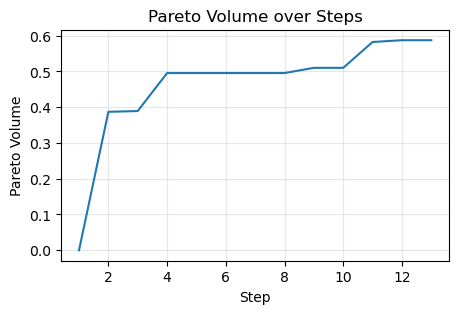

In [95]:
plt.figure(figsize=(5, 3))
plt.plot(*dataframes['scalar_search/data/summaries/pareto_volume'][['step', 'value']].values.T, marker='', linestyle='-')
plt.xlabel('Step')
plt.ylabel('Pareto Volume')
plt.title('Pareto Volume over Steps')
plt.grid(True, alpha=0.3)
plt.show()


In [73]:
list(dataframes.items())[20]

('tensor_search/data/equations/complexity=6/equation',
            wall_time step                                    value
 0  1746129954.287252    2  exp(sin(-0.5373826240871764)) / exp(x3)
 1  1746129958.485164    3  exp(sin(-0.5373826240871764)) / exp(x3)
 2  1746129959.807789    4  exp(sin(-0.5373826240871764)) / exp(x3))

In [89]:
event_acc.Histograms('search/data/population/complexities')[0].histogram_value

HistogramValue(min=0.0, max=35.0, num=7.0, sum=837.0, sum_squares=138881.0, bucket_limit=[5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0], bucket=[163.0, 87.0, 42.0, 108.0, 243.0, 179.0, 15.0])

In [22]:
event_acc.Scalars('search/data/equations/complexity=1/loss')[0]

ScalarEvent(wall_time=1746129950.888995, step=1, value=0.009403901174664497)

In [58]:
event_acc.Tensors('search/data/equations/complexity=1/equation')[0].tensor_proto.string_val[0].decode('utf-8').strip('"')

'0.06045546064679162'

In [49]:
dir(event_acc.Tensors('search/data/equations/complexity=1/equation')[0].tensor_proto)

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'ParseFromString',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'UnknownFields',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_ListFieldsItemKey',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__']

In [8]:
event_acc.Scalars('search/data/summaries/min_loss')[0]

ScalarEvent(wall_time=1746129950.888995, step=1, value=0.009403901174664497)

In [ ]:
losses = np.array([(e.wall_time, e.step, e.value) for e in event_acc.Scalars('search/data/summaries/min_loss')])

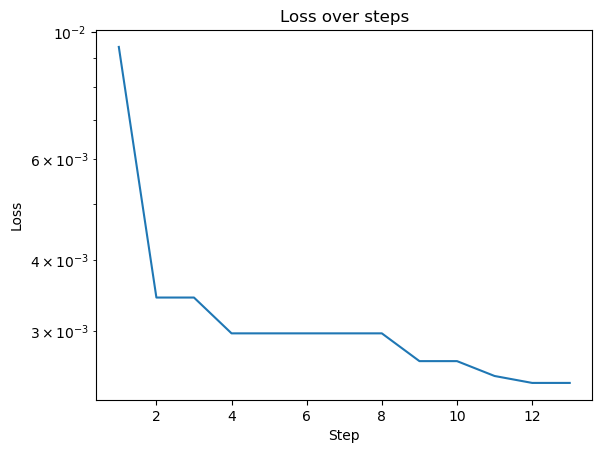

In [10]:
plt.plot(losses[:, 1], losses[:, 2])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over steps')
plt.yscale('log')
plt.show()


## Choosing operators

In [78]:
fpath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/data/FeynmanEquations.csv'
df = pd.read_csv(fpath)
df.head()


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,...,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2a,1.0,f,exp(-theta**2/2)/sqrt(2*pi),1.0,theta,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2,2.0,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.6.2b,3.0,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...,3.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.8.14,4.0,d,sqrt((x2-x1)**2+(y2-y1)**2),4.0,x1,1.0,5.0,x2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I.9.18,5.0,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9.0,m1,1.0,2.0,m2,1.0,...,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN


In [84]:
'log' in df.Formula.str.cat()

False

In [87]:
def find_remaining_ops(formulas):
    operators = ['exp', '*', '**', '/', '+', '-', 'sqrt', 'sin', 'cos', 'tan', 'sinh', 'cosh', 'tanh']
    
    # First count the known operators
    operator_counts = {}
    for formula in formulas.dropna():
        for op in operators:
            # For *, don't count occurrences that are part of **
            if op == '*':
                count = formula.count('*') - 2 * formula.count('**')
            else:
                count = formula.count(op)
            if count > 0:
                operator_counts[op] = operator_counts.get(op, 0) + count
    
    print("Known operator counts:")
    print(pd.Series(operator_counts).sort_values(ascending=False))
    
    # Then remove all known operators and see what's left
    print("\nRemainder after removing known operators:")
    remaining = formulas.copy()
    for op in operators:
        remaining = remaining.str.replace(op, ' ', regex=False)
    
    # Remove numbers, variables, spaces and parentheses
    remaining = remaining.str.replace(r'[0-9]', '', regex=True)
    remaining = remaining.str.replace(r'[a-zA-Z]', '', regex=True)
    remaining = remaining.str.replace(r'[\s\(\)]', '', regex=True)
    remaining = remaining.str.replace('.', '', regex=False)
    
    # Print unique remaining characters
    print("Unique remaining characters:", sorted(set(''.join(remaining.dropna()))))

find_remaining_ops(df.Formula)

Known operator counts:
*       255
/       138
**       87
-        45
+        30
sqrt     18
sin      11
cos      11
exp      10
tan       1
tanh      1
dtype: int64

Remainder after removing known operators:
Unique remaining characters: ['_']


In [86]:
df.Formula.dropna()

0                           exp(-theta**2/2)/sqrt(2*pi)
1           exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)
2     exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...
3                           sqrt((x2-x1)**2+(y2-y1)**2)
4            G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
                            ...                        
95                           (h/(2*pi))**2/(2*E_n*d**2)
96                                     2*pi*alpha/(n*d)
97                            beta*(1+alpha*cos(theta))
98    -m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1...
99                                   -rho_c_0*q*A_vec/m
Name: Formula, Length: 100, dtype: object

## Reading whole benchmark's Tensorboard data

/tmp/ipykernel_2540983/928570358.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')  # Use tab20 colormap which has 20 distinct colors


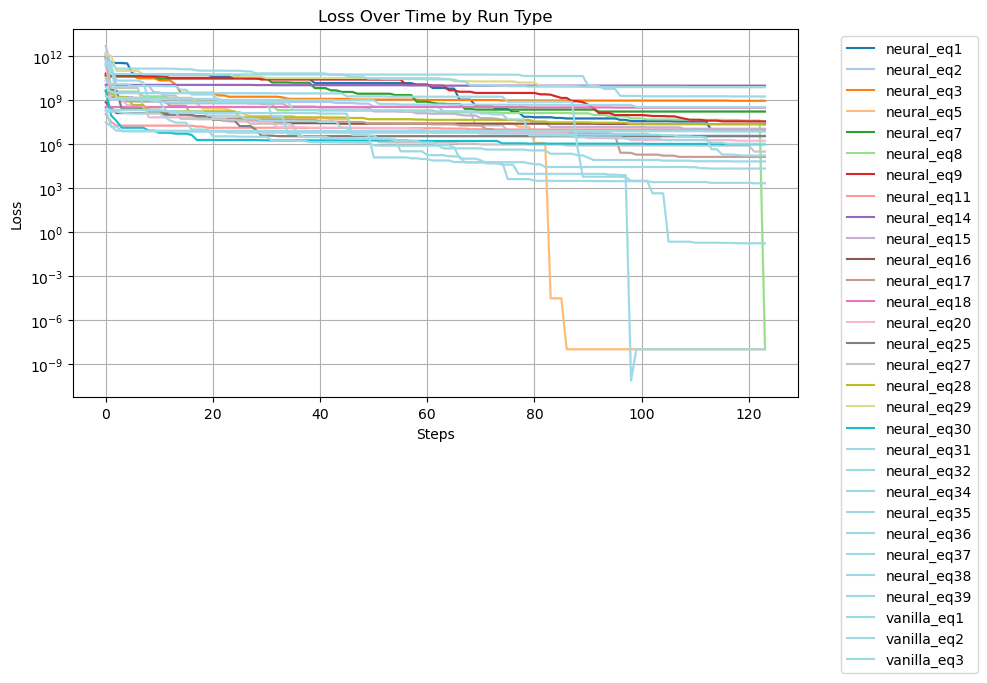

In [5]:
plot_losses({k: v for i, (k, v) in enumerate(losses.items()) if i < 30})

In [6]:
len(losses.keys())

54

In [7]:
def plot_threshold_counts(loss_arrays, threshold=1e-8):
    # Get max length across all arrays to standardize x-axis
    max_len = max(arr.shape[0] for arr in loss_arrays.values())
    steps = np.arange(max_len)
    
    # Group prefixes by type (neural vs vanilla)
    neural_losses = []
    vanilla_losses = []
    
    for prefix, losses in loss_arrays.items():
        if 'neural' in prefix:
            neural_losses.append(losses)
        elif 'vanilla' in prefix:
            vanilla_losses.append(losses)
    
    # Calculate counts below threshold at each timestep
    def get_counts_over_time(loss_list):
        if not loss_list:  # Handle empty lists
            return np.zeros(max_len)
            
        counts = np.zeros(max_len)
        for t in range(max_len):
            # Count how many equations have mean loss below threshold
            total = 0
            for losses in loss_list:
                if t < losses.shape[0]:  # Only count if we have data for this timestep
                    mean_loss = np.mean(losses[t,:])  # Take mean across runs
                    if mean_loss < threshold:
                        total += 1
            counts[t] = total
        return counts
    
    neural_counts = get_counts_over_time(neural_losses)
    vanilla_counts = get_counts_over_time(vanilla_losses)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    if len(neural_losses) > 0:
        plt.plot(steps, neural_counts, label='Neural', color='blue')
    if len(vanilla_losses) > 0:
        plt.plot(steps, vanilla_counts, label='Vanilla', color='red')
    
    plt.xlabel('Steps')
    plt.ylabel(f'Number of Equations with Mean Loss Below {threshold:0.0e}')
    plt.title('Count of Successful Equations Over Time')
    plt.ylim(0, len(loss_arrays.keys())//2)
    plt.xlim(0, 125)
    plt.legend()
    plt.grid(True)
    plt.show()


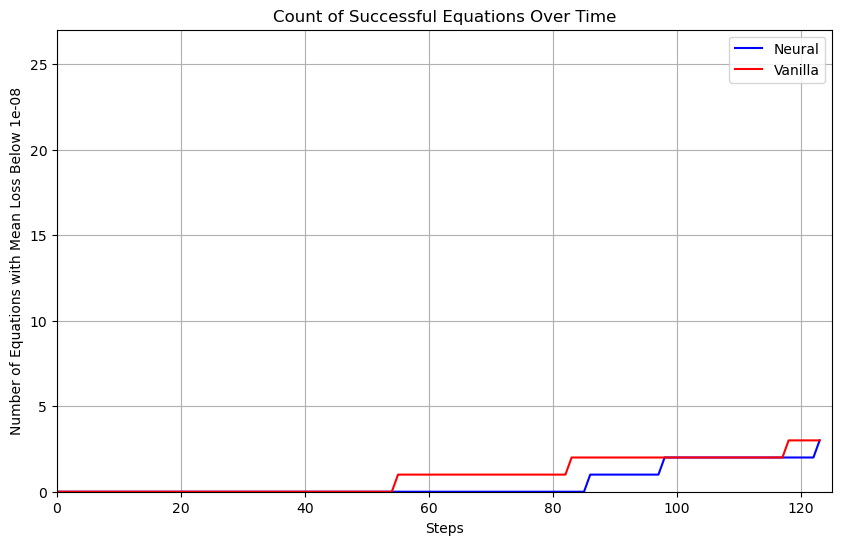

In [8]:
plot_threshold_counts(losses, threshold=1.1e-8)

### Synthetic run 3 (names synthetic7_)

run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: full6_
  do_vanilla: true
  do_neural: true

dataset:
  name: synthetic
  num_samples: 100000  # Same settings as full1_
  noise: 0
  equation_indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.02
    subtree_min_nodes: 2
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 8
    require_tree_size_similarity: true
    require_novel_skeleton: true
    require_expr_similarity: true
    similarity_threshold: 0.2  # Using double actual similarity_threshold to speed up computation
    log_subtree_strings: false
    sample_logits: true
    max_resamples: 127
    sample_batchsize: 32

  weight_neural_mutate_tree: 1.0  # Only used for neural runs.

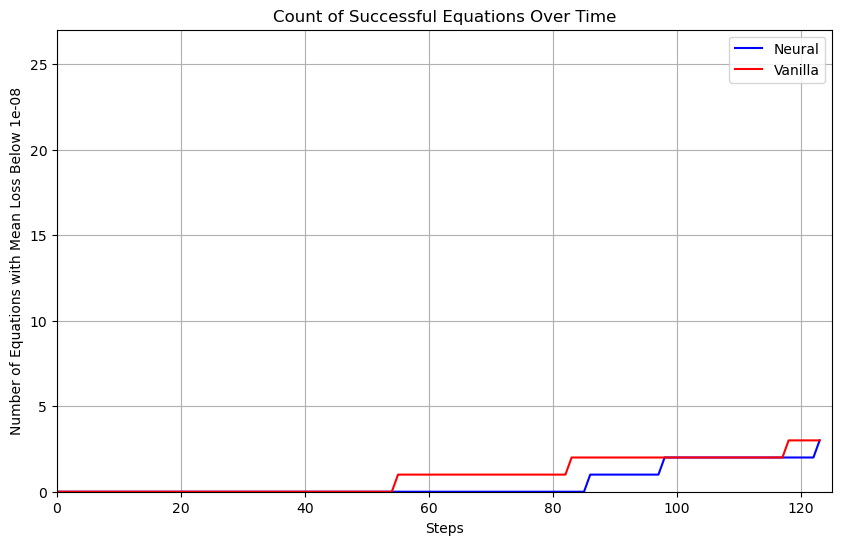

In [40]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Synthetic run 2
Added resmpling and other checks

run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: syntheticNoLog2_
  do_vanilla: true
  do_neural: true

dataset:
  name: synthetic
  num_samples: 10000  # Same settings as full1_
  noise: 0
  equation_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]  # , 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.02
    subtree_min_nodes: 2
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 9
    max_resamples: 29
    require_tree_size_similarity: true
    require_novel_skeleton: true
    require_expr_similarity: true
    similarity_threshold: 0.4  # Using double actual similarity_threshold to speed up computation
  weight_neural_mutate_tree: 1.0  # Only used for neural runs. 

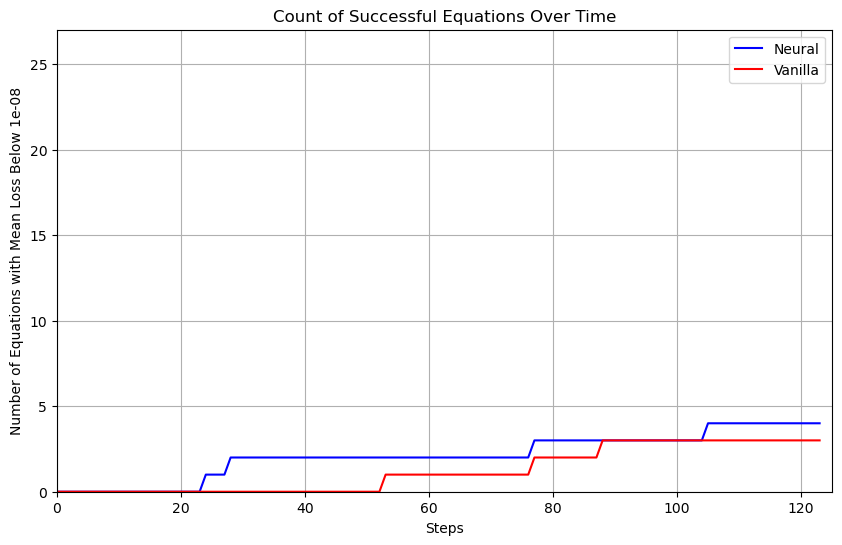

In [24]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Synthetic run 1
run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: syntheticNoLog1_
  do_vanilla: true
  do_neural: true

dataset:
  name: synthetic
  num_samples: 10000  # Same settings as full1_
  noise: 0
  equation_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]  # , 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.03
    subtree_min_nodes: 3
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 7
    max_resamples: 9
  weight_neural_mutate_tree: 1.0  # Only used for neural runs. 

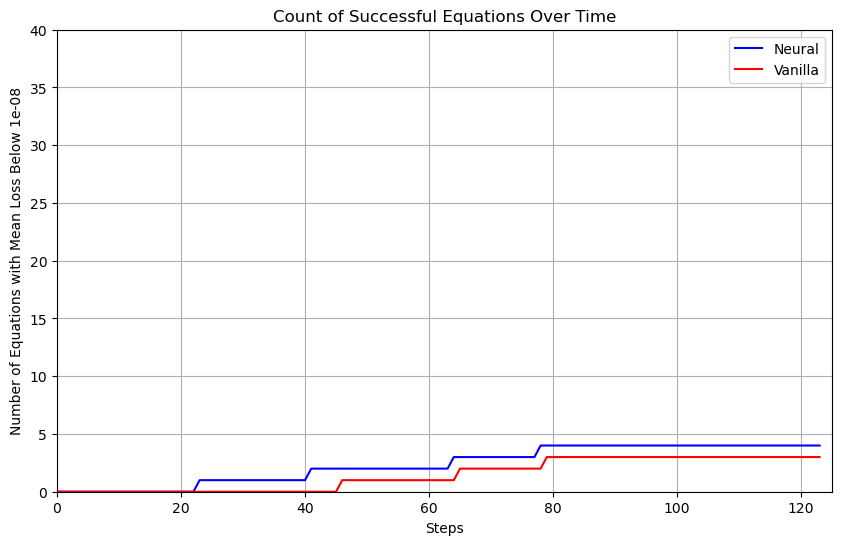

In [40]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Run 4
10k points, noise=0, with resampling

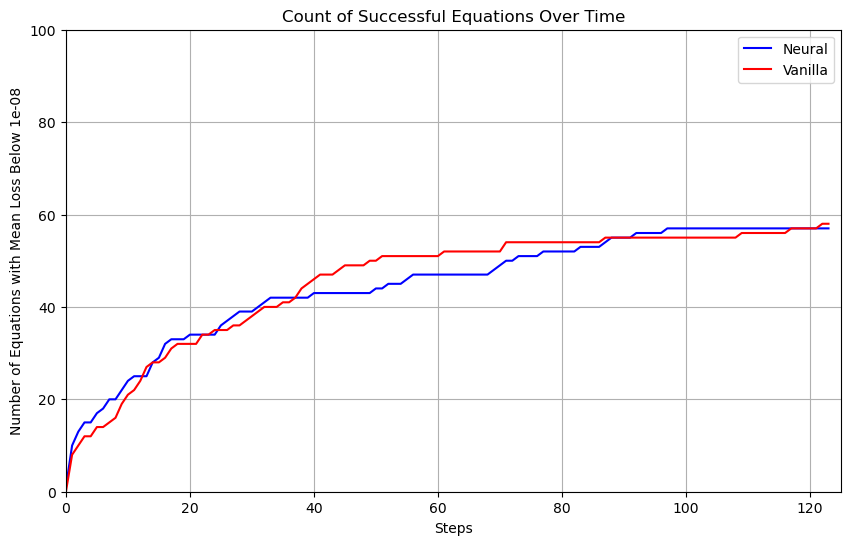

In [11]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Run 2
100k points, noise=1e-3

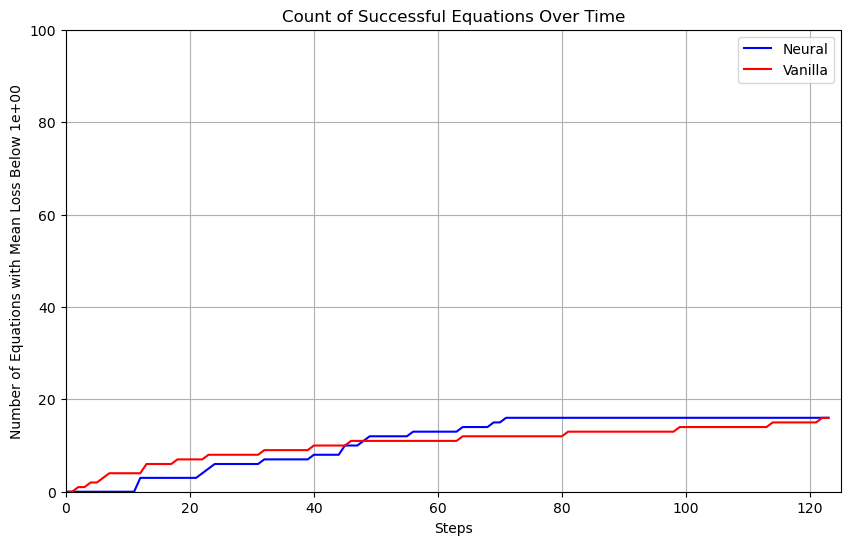

In [40]:
# Plot using the losses from previous cell
plot_threshold_counts(losses, threshold=1.1e0)


## Run 1
10k points, no noise

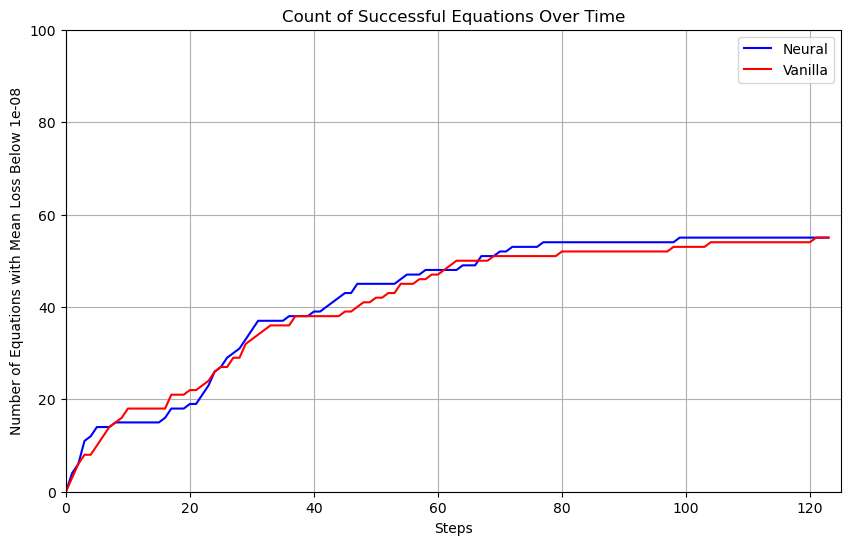

In [27]:
# Plot using the losses from previous cell
plot_threshold_counts(losses, threshold=1.1e-8)


### Run 6

run_settings:
  n_runs: 1
  max_iter: 40
  early_stopping_condition: 1e-8
  log_dir: /cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs

  run_prefix: full6_
  do_vanilla: true
  do_neural: true

dataset:
  name: feynman
  num_samples: 100000  # Same settings as full1_
  noise: 1e-3
  equation_indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  forbid_ops: [log]

symbolic_regression:
  neural_options:
    active: true
    model_path: /home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-e51hcsb9.onnx
    sampling_eps: 0.02
    subtree_min_nodes: 2
    subtree_max_nodes: 14
    device: cuda
    verbose: true
    max_tree_size_diff: 9
    max_resamples: 29
    require_tree_size_similarity: true
    require_novel_skeleton: true
    require_expr_similarity: true
    similarity_threshold: 0.4  # Using double actual similarity_threshold to speed up computation
  weight_neural_mutate_tree: 1.0  # Only used for neural runs. 






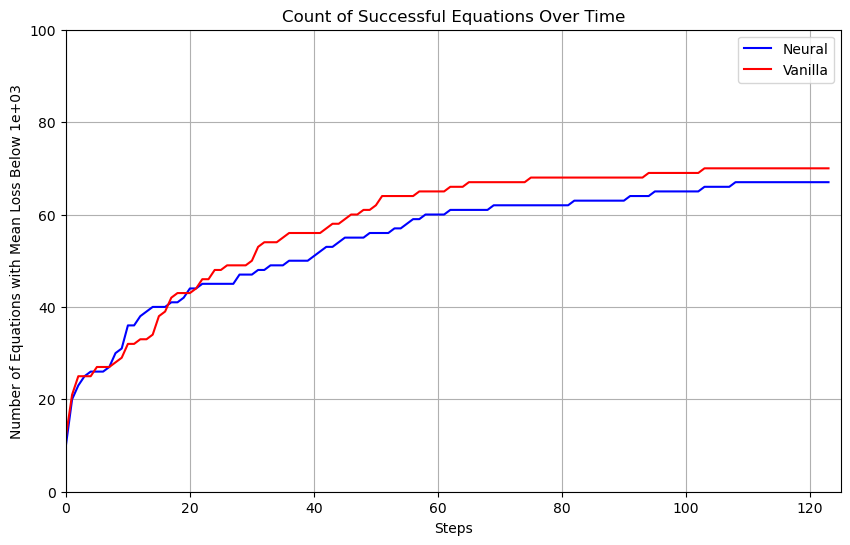

In [15]:
plot_threshold_counts(losses, threshold=1.1e3)